# Sparse Identification of Induction Motor Nonlinear Dynamics in Unbalanced Conditions

**Table of Contents**
<!-- TOC -->
* [Sparse Identification of Induction Motor Nonlinear Dynamics in Unbalanced Conditions](#sparse-identification-of-induction-motor-nonlinear-dynamics-in-unbalanced-conditions)
  * [Description](#description)
  * [Installation](#installation)
    * [Prerequisites](#prerequisites)
    * [Dependencies](#dependencies)
  * [Configuration](#configuration)
    * [Choice of Regularization](#choice-of-regularization)
    * [Choice of Library](#choice-of-library)
  * [Usage](#usage)
    * [1) Data Generation](#1-data-generation)
    * [2) Data Preparation](#2-data-preparation)
    * [3) Optimization of hyperparameters](#3-optimization-of-hyperparameters)
    * [4) Model Identification](#4-model-identification)
    * [5) Model Evaluation](#5-model-evaluation)
  * [Additional Info](#additional-info)
<!-- TOC -->

## Description
This project aims to identify a model feasible for control purposes of an induction machine. 
This is obtained by a data-driven based system identification called 'SINDy with control' or 'SINDYc', 
solving the differential equation 
```math
\dot{X} = f(x,u)
```
where $`X`$ is the state vector, $`u`$ is the input control vector and $`f`$ is the function to be identified. 
SINDYc uses a library of candidate functions to identify the dynamics of the system $`\Theta(X)`$ and a sparse vector
$`\Xi`$ to be identified, such that
```math
\dot{X} = \Theta(X) \Xi
```
In this project, the l1 regularization is used to enforce sparsity in the solution.
We aim to find a dynamical model of the stator current $`i_{dq0,s}`$ by using $`x = [i_{dq0,s}]`$ 
and $`u = [v_{dq0,s}, \int_0^t i_{dq0,s}(\tau)d\tau, \int_0^t v_{dq0,s}(\tau)d\tau, \gamma^r, \omega^r]`$ as
the state and input vectors, respectively.
Here, $`v_{dq0,s}`$ is the stator voltage, $`\gamma^r`$ is the rotor angle 
and $`\omega^r`$ is the rotor angular speed.

Additionally, Torque and UMP are also identified through little manipulation to the SINDYc model.

Static and dynamic eccentricities are considered.

The data is obtained from simulations using the Python package IMMEC.

## Installation
### Prerequisites
### Dependencies
<!-- pip install or conda install !-->

## Configuration
### Choice of Regularization
example text


### Choice of Library
For pySINDy to work, a library of candidate functions must be defined. 
Predefined libraries from pySINDy are polynomials or Fourier terms, though pySINDy allows for
custom libraries to be defined and fine-tuned for each input variable. 
Some of our own libraries are predefined in `libs.py` and can be called by the user: `get_custom_library_funcs('nonlinear_terms')`.

## Usage

### 1) Data Generation
The data generation is completely distict from the other aspects of the project. 
It uses the time-stepping solver IMMEC to model the induction machine and obtain the data.
The user can generate the data by running the script `data_generation.py` and setting the parameters in the script.
The user can choose to generate test or training data, resulting in one or multiple (`numbr_of_simulations`) 
simulations respectively. An initial eccentricity can also be set by `ecc_value` (value between 0 and 1) and `ecc_dir` 
(the direction in $`x, y`$ coordinates). The mode can be set to `linear`or `nonlinear` to simulate the machine.

The function automatically creates a folder inside the `train-data` or `test-data` folder with the name of the date, 
and saves the simulation data in a `.npz`-file with the name provided by the user by `save_name`.

The `.npz`-file contains the following arrays:
- `i_st` - Stator current
- `omega_rot` - Rotor angular speed
- `T_em` - Electromagnetic torque
- `F_em` - Electromagnetic force or UMP
- `v_applied` - Applied line voltages
- `T_l` - Load torque
- `ecc` - Eccentricity
- `time` - Simulated time
- `flux_st_yoke` - Stator yoke flux
- `gamma_rot` - Rotor angle
- `wcoe` - Magnetic coenergy

If multiple simulations are saved in one file, which is the case for traindata, 
the arrays have an additional (3rd) dimension for each simulation.

In [ ]:
### DATA TRAINING FILES
path_to_data_files = os.path.join(os.getcwd(), 'train-data', '07-29-default', 'IMMEC_0ecc_5.0sec.npz')

### DATA TEST FILES
path_to_test_file = os.path.join(os.getcwd(), 'test-data', '07-29', 'IMMEC_0ecc_5.0sec.npz')

### 2) Data Preparation
COMMENT FOR THE AUTHOR: this function is just very important and useful if the `train_model.py` is not as desired. 


In order to create a model, the training data must be prepared. This is done in the script `data_preparation.py`, which is 
called by the  `prepare_data()` function during training and postprocessing by other scripts. The user can call this function if desired,
but this is not necessary. The function takes the following arguments:
- `path_to_data_file` - Path to the `.npz`-file containing the data
- `test_data` - default False, this omits the extra preparation needed for trainingdata
- `number_of_trainfiles` - default -1 (all files), can be set to a number if not all simulations should be considered. The choice of selected simulations is random. This can be useful to reduce the training samples for large datasets.
- `use_estimate_for_v` - default False, if True, the `v_abc` are estimated from the line voltages.
- `usage_per_trainfile` - default 0.5, the percentage of the data used from each simulation.
- `ecc_input`- default False, if True, the eccentricity is used as an input variable to the model.

The function returns a dictionary containing the following arrays:
- `x`- Currents
- `u`- Input values, if `ecc_input` is True, the eccentricity is also included
- `xdot` - Time derivative of the currents
- `feature_names` - Names of the features to pass to the SINDy model

Additionally, as one might want to fit a SINDy model for the torque or UMP (by replacing `xdot`), the following are also present:
- `UMP` - Unbalanced magnetic pull
- `T_em` - Electromagnetic torque
- `wcoe` - The magentic coenergy



If the data is trainingsdata, it is split up into train and validation data (80% - 20%),    
in which case the dictionary also contains all the previous values but ending with `_train` and `_val`. 

### 3) Optimization of hyperparameters
Assuming the data generation is done, the user can start the optimization of the hyperparameters. 

<!-- insert here the tutorial for the optuna study and also the plot itself to choose parameters -->


As described in [this section](#choice-of-regularisation), the Lasso and SR3 regulators are considered, 
yielding 1 and 2 hyperparameters respectively. Hence, the validation data is used to select the best parameter values. 
This can be combined with various selections of library candidate functions, enlarging the search-space.

For this purpose, a Python package called `Optuna` is used, which searches for the pareto-optimal solution. 
The user can initialise a study by calling the function `optimize_parameters()` from the script `optimize_parameters.py`, by which a study is created.
The function requires the following arguments:
- `path_to_data_files` - Path to the `.npz`-file containing the training data
- `mode`- default 'torque', can be set to 'ump', 'currents' or 'wcoe', specifying what the model predicts
- `additional_name` - default None, a string that is added to the name of the study
- `n_jobs` - default 1, number of cores to be used for the optimization, to run in paralell
- `n_trials` - default 100, number of trials to be performed per core

The ranges of the parameters are predefined inside the function, but can be changed by the user. 
The library candidate functions are called from `libs.py` by the function `get_library_names()` during the search. 
The user should set the desired libraries by changing the returned values of this function. 

The resulting study is saved in the `optuna_studies` folder, which can be accessed by calling the `plot_optuna_data()` function from the same script.

<!-- insert an optuna plot here -->



### 4) Model Identification
Now the desired hyperparameters and optimiser are known, the user can start the model identification. 
This is done by calling the function `make_model()` from the script `train_model_source.py`. The function requires the following arguments:
- `path_to_data_files` - Path to the `.npz`-file containing the training data
- `modeltype`- Can be set to 'torque', 'ump', 'torque-ump', 'currents' or 'wcoe', specifying what the model predicts
- `optimizer`- Either 'lasso' or 'sr3', specifying the regularisation method
- `lib` - The chosen library candidate functions
- `nmbr_of_train` - default -1 (all files), can be set to a number if not all simulations should be considered.
- `alpha` - default None, the regularisation parameter for lasso
- `nu` - default None, the first regularisation parameter for sr3
- `lamb` - default None, the second regularisation parameter for sr3
- `model_name` - default None, a string that is added to the name of the model

When a model is created, it is saved as a `.pkl`-file in the `models` folder. The model can be loaded by calling the `load_model()` function from `source.py`.


### 5) Model Evaluation
Now, the model's performance can be evaluated on the test data. This is done by calling the function `simulate_model()`
from the script `train_model_source.py`. The function requires the following arguments:
- `model_name` - The name of the model from the `models` folder
- `path_to_test_file` - Path to the `.npz`-file containing the test data
- `modeltype`- Can be set to 'torque', 'ump', 'torque-ump', 'currents' or 'wcoe', specifying what the model predicts
- `do_time_simulation` - default False, only relevant if `modeltype` == 'currents'. Then the `xdot` is solved by `solve_ivp` 
to retrieve the prediction of `x`

This function returns the predicted and expected values. These can also be plotted in the frequency domain by the `plot_fourier()` function from `source.py`.


## Additional Information
### Examples

($i_d$)' = 0.997 $V_d$$i_q$ + -0.027 $V_d$$I_d$ + 0.063 $V_d$$I_q$ + -0.993 $V_q$$i_d$ + 6.198 $i_d$$I_q$ + -6.212 $i_q$$I_d$ + 0.006 $i_q$$I_q$ + 0.245 $I_d$$I_d$ + -0.632 $I_d$$I_q$
Loading data
Done loading data
Calculating xdots
Assume all t_vec are equal
Done calculating xdots
No ecc
MSE on test:  0.00024317106593114683
Non-zero elements:  9
MSE simplified model 2.8984220512564188e-05


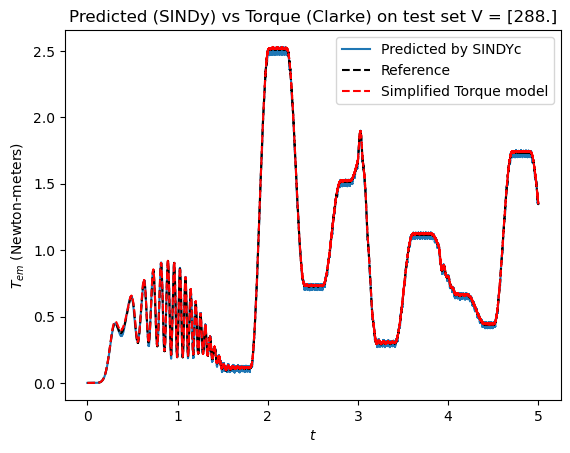

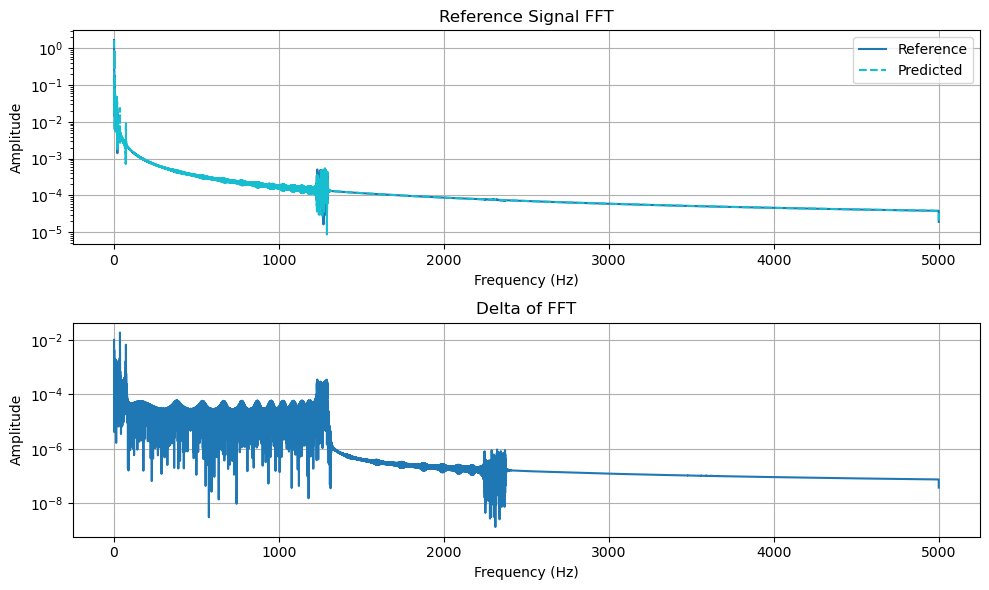

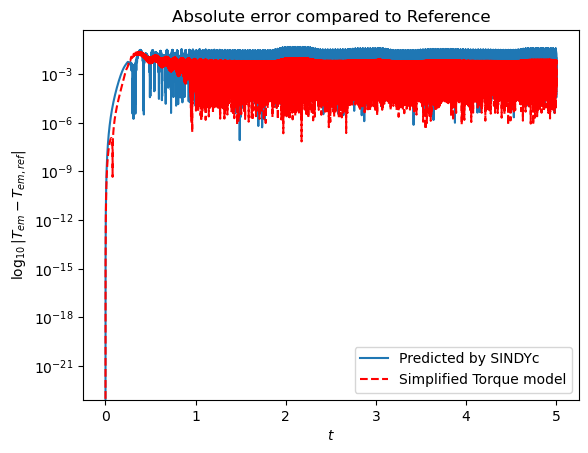

($i_d$)' = -0.003 $V_d$$V_d$ + 0.993 $V_d$$i_q$ + -0.001 $V_d$$I_d$ + 0.052 $V_d$$I_q$ + -0.990 $V_q$$i_d$ + -0.018 $V_q$$I_d$ + 0.001 $V_q$$I_q$ + 6.167 $i_d$$I_q$ + -6.154 $i_q$$I_d$ + 0.396 $I_d$$I_d$ + -0.762 $I_d$$I_q$ + -0.054 $I_q$$I_q$
Loading data
Done loading data
Calculating xdots
Assume all t_vec are equal
Done calculating xdots
No ecc
MSE on test:  0.00015329636290841952
Non-zero elements:  13
MSE simplified model 2.8984220512564188e-05


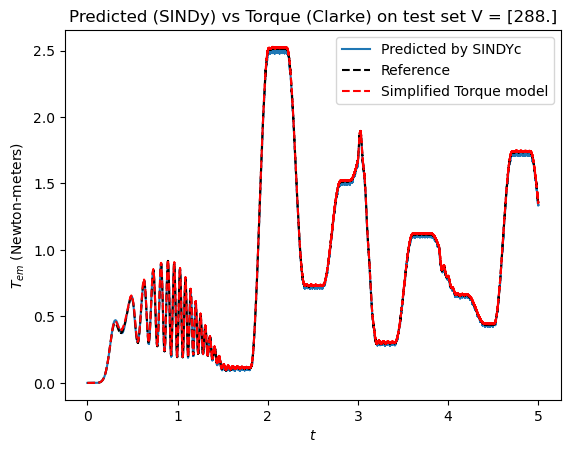

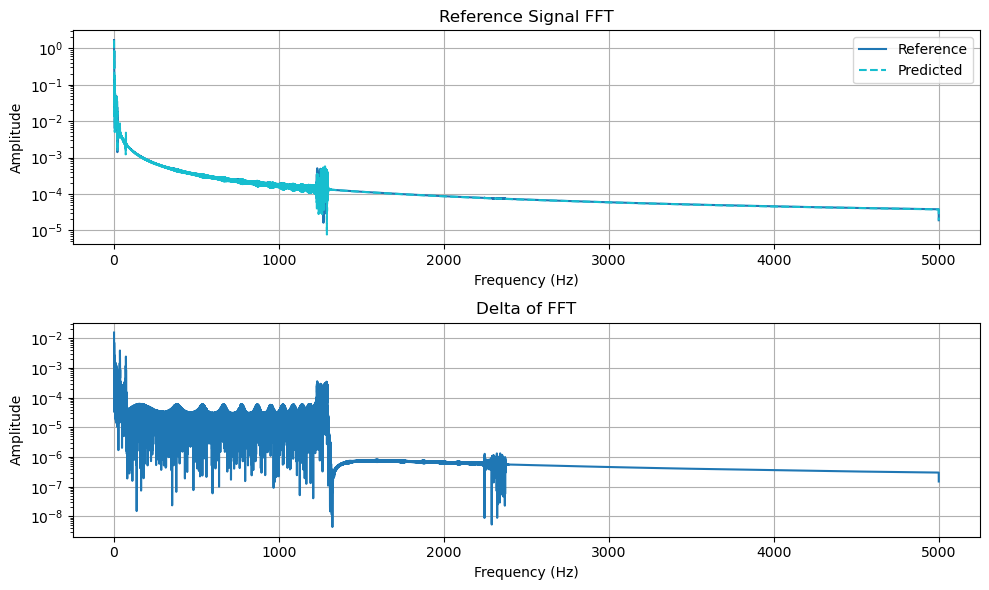

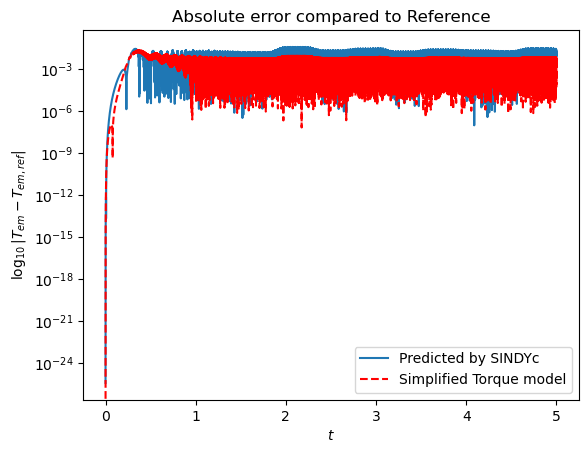

In [3]:
import os

from optimize_parameters import parameter_search, optimize_parameters, plot_optuna_data
from source import *
from train_model_source import make_model, simulate_model

do_part1 = False
do_part2 = False
do_part3 = False
do_part4 = True

### PART 1: OPTIMIZE PARAMETERS
if do_part1:
    # mode is either "currents", "torque" or "ump" (TO BE IMPLEMENTED W_mag)
    # Creates an optuna study to optimize the parameters of the
    optimize_parameters(path_to_data_files, mode="wcoe", additional_name="W_linear")

### PART 2: plot the optuna study to choose the hyperparameters
if do_part2:
    #plot_optuna_data('currents-optuna-study', dirs = 'w3-presentation-0208//')
    #plot_optuna_data('currentsLinear-specific-optuna-study')
    #plot_optuna_data('ump_dynamic-optuna-study')
    plot_optuna_data('W_linear-optuna-study')

### PART 3: TRAIN MODEL
if do_part3:
    make_model(path_to_data_files, modeltype='torque', optimizer='sr3',
               nmbr_of_train=-1, lib='poly_2nd_order', nu=1.978e-10, lamb=5.3e-9,
               modelname='jupy')
 
### PART 4: SIMULATE MODEL
if do_part4:
    models = [ "example_A_currents"] #"example_A_currents",
    models = ["linear_example_new_1_currents", "linear_example_2_currents", "linear_example_3_currents"]
    models = ["currents_nonlinear"]
    models = ["torque_linear", "torque_linear_2"]
    pref = "0908//"
    pref = "torque_linear//"

    for m in models:
        # simulate the model and plot the results
        pr, test = simulate_model(pref+m+'_model', path_to_test_file, modeltype="torque", do_time_simulation=False, show=True)
    plt.show()